# 60分钟入门深度学习工具-PyTorch(四、训练一个分类器)
**作者**：Soumith Chintala


原文翻译自：https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
    
中文翻译、注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：PyTorch 1.0，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](images/gongzhong.jpg)
### 目录
* 1.[Pytorch是什么？](60分钟入门PyTorch-1.PyTorch是什么？.ipynb)
* 2.[AUTOGRAD](60分钟入门PyTorch-2.AUTOGRAD.ipynb)
* 3.[神经网络](60分钟入门PyTorch-3.神经网络.ipynb)
* 4.[训练一个分类器](60分钟入门PyTorch-4.训练一个分类器.ipynb)
* 5.[数据并行](60分钟入门PyTorch-5.数据并行.ipynb)

# 四、训练一个分类器

你已经学会如何去定义一个神经网络,计算损失值和更新网络的权重。

你现在可能在思考：数据哪里来呢？


## 关于数据


通常，当你处理图像，文本，音频和视频数据时，你可以使用标准的Python包来加载数据到一个numpy数组中.然后把这个数组转换成`torch.*Tensor`。
* 对于图像,有诸如Pillow,OpenCV包等非常实用
* 对于音频,有诸如scipy和librosa包
* 对于文本,可以用原始Python和Cython来加载,或者使用NLTK和SpaCy
对于视觉,我们创建了一个`torchvision`包,包含常见数据集的数据加载,比如Imagenet,CIFAR10,MNIST等,和图像转换器,也就是`torchvision.datasets`和`torch.utils.data.DataLoader`。

这提供了巨大的便利,也避免了代码的重复。

在这个教程中,我们使用CIFAR10数据集,它有如下10个类别:’airplane’,’automobile’,’bird’,’cat’,’deer’,’dog’,’frog’,’horse’,’ship’,’truck’。这个数据集中的图像大小为3\*32\*32,即,3通道,32\*32像素。


![cifar10](images/cifar10.png)

### 训练一个图像分类器

我们将按照下列顺序进行:
* 使用`torchvision`加载和归一化CIFAR10训练集和测试集.
* 定义一个卷积神经网络
* 定义损失函数
* 在训练集上训练网络
* 在测试集上测试网络

### 1. 加载和归一化CIFAR0
使用`torchvision`加载CIFAR10是非常容易的。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision的输出是[0,1]的PILImage图像,我们把它转换为归一化范围为[-1, 1]的张量。

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#这个过程有点慢，会下载大约340mb图片数据。

Files already downloaded and verified
Files already downloaded and verified


我们展示一些有趣的训练图像。

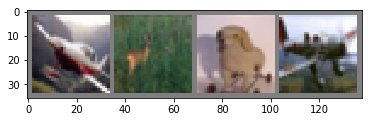

plane  deer   dog plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 定义一个卷积神经网络

从之前的神经网络一节复制神经网络代码,并修改为接受3通道图像取代之前的接受单通道图像。

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. 定义损失函数和优化器

我们使用交叉熵作为损失函数,使用带动量的随机梯度下降。

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 训练网络

这是开始有趣的时刻，我们只需在数据迭代器上循环,把数据输入给网络,并优化。

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.286
[1,  4000] loss: 1.921
[1,  6000] loss: 1.709
[1,  8000] loss: 1.618
[1, 10000] loss: 1.548
[1, 12000] loss: 1.496
[2,  2000] loss: 1.435
[2,  4000] loss: 1.409
[2,  6000] loss: 1.373
[2,  8000] loss: 1.348
[2, 10000] loss: 1.326
[2, 12000] loss: 1.313
Finished Training


### 5. 在测试集上测试网络

我们在整个训练集上训练了两次网络,但是我们还需要检查网络是否从数据集中学习到东西。

我们通过预测神经网络输出的类别标签并根据实际情况进行检测，如果预测正确,我们把该样本添加到正确预测列表。

第一步，显示测试集中的图片一遍熟悉图片内容。

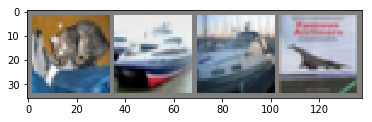

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

现在我们来看看神经网络认为以上图片是什么?

In [8]:
outputs = net(images)

输出是10个标签的概率。一个类别的概率越大,神经网络越认为他是这个类别。所以让我们得到最高概率的标签。

In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


这结果看起来非常的好。

接下来让我们看看网络在整个测试集上的结果如何。

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


结果看起来好于偶然，偶然的正确率为10%,似乎网络学习到了一些东西。

那在什么类上预测较好，什么类预测结果不好呢？

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 63 %
Accuracy of  bird : 43 %
Accuracy of   cat : 33 %
Accuracy of  deer : 36 %
Accuracy of   dog : 46 %
Accuracy of  frog : 68 %
Accuracy of horse : 62 %
Accuracy of  ship : 80 %
Accuracy of truck : 63 %


接下来干什么?

我们如何在GPU上运行神经网络呢?

### 在GPU上训练
你是如何把一个Tensor转换GPU上,你就如何把一个神经网络移动到GPU上训练。这个操作会递归遍历有所模块,并将其参数和缓冲区转换为CUDA张量。

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
#假设我们有一台CUDA的机器，这个操作将显示CUDA设备。
print(device)

cuda:0


接下来假设我们有一台CUDA的机器，然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量：

In [13]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，你也必须在每一步中把你的输入和目标值转换到GPU上:

In [14]:
inputs, labels = inputs.to(device), labels.to(device)

为什么我们没注意到GPU的速度提升很多?那是因为网络非常的小。

#### 实践:
尝试增加你的网络的宽度(第一个`nn.Conv2d`的第2个参数, 第二个`nn.Conv2d`的第一个参数,他们需要是相同的数字),看看你得到了什么样的加速。

#### 实现的目标:
* 深入了解了PyTorch的张量库和神经网络
* 训练了一个小网络来分类图片

### 在多GPU上训练
如果你希望使用所有GPU来更大的加快速度,请查看选读:[数据并行](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

接下来做什么?
* 训练神经网络玩电子游戏
* 在ImageNet上训练最好的ResNet
* 使用对抗生成网络来训练一个人脸生成器
* 使用LSTM网络训练一个字符级的语言模型
* 更多示例
* 更多教程
* 在论坛上讨论PyTorch
* 在Slack上与其他用户聊天

本章的官方代码：
* Python：[cifar10_tutorial.py](download/cifar10_tutorial.py)
* Jupyter notebook:[cifar10_tutorial.ipynb](download/cifar10_tutorial.ipynb)